In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd 
import sys 
from glob import glob 
from jaxparrow import cyclogeostrophy, geostrophy
from datetime import datetime, timedelta

In [5]:
list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_duacs_RonanUnet/daily/unet_rec_*.nc"))
imt = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')

In [12]:
list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/duacs_15m_8th/daily/duacs_15m_8th_*.nc"))
duacs = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
duacs = duacs.rename({"longitude":"lon"})
duacs = duacs.rename({"latitude":"lat"})
#duacs
#duacs = duacs.sel(lat=slice(-70,70))
duacs = duacs.interp(lon=imt.lon,lat=imt.lat,method="linear")

lon = duacs.lon.values
lat = duacs.lat.values
lon2D, lat2D = np.meshgrid(lon, lat)


In [ ]:
# Définir la date de début et de fin
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 1, 2)
#end_date = datetime(2019, 12, 31)

# Boucler sur chaque jour de 2019
current_date = start_date 

vrt_list = []

while current_date <= end_date:
    duacs_cyclo = imt.sel(time=current_date)
    duacs_geo = duacs.sel(time=current_date)
    time_target = current_date.strftime("%Y-%m-%d")
    (u_geo,v_geo,lat_u, lon_u, lat_v, lon_v) = cyclogeostrophy(duacs_geo.adt.values, lat2D, lon2D)
    duacs_cyclo.ugos.values = u_geo
    duacs_cyclo.vgos.values = v_geo
    duacs_cyclo.to_netcdf(f"rec/duacs_cyclo_{time_target}.nc", 'w', format="NETCDF4")
    current_date += timedelta(days=1)


In [3]:
sys.path.append("/Odyssey/private/t22picar/tools/")
from plot_tools import plot_uv_map,plot_map_zoom,plot_map_multizoom

duacs_cyclo = xr.open_dataset("/Odyssey/private/t22picar/process_data/cyclogeo/rec/duacs_cyclo_8th_2019-01-04.nc")

duacs  = xr.open_dataset("/Odyssey/private/t22picar/multivar_drifter/rec/duacs_15m_8th/daily/duacs_15m_8th_2019-01-04.nc")
duacs = duacs.rename({"longitude":"lon"})
duacs = duacs.rename({"latitude":"lat"})
#duacs = duacs.interp(lon=duacs_cyclo.lon,lat=duacs_cyclo.lat,method="linear")



/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N
/Odyssey/private/t22picar/miniforge3/envs/4dvarnet-daniel/lib/python3.10/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


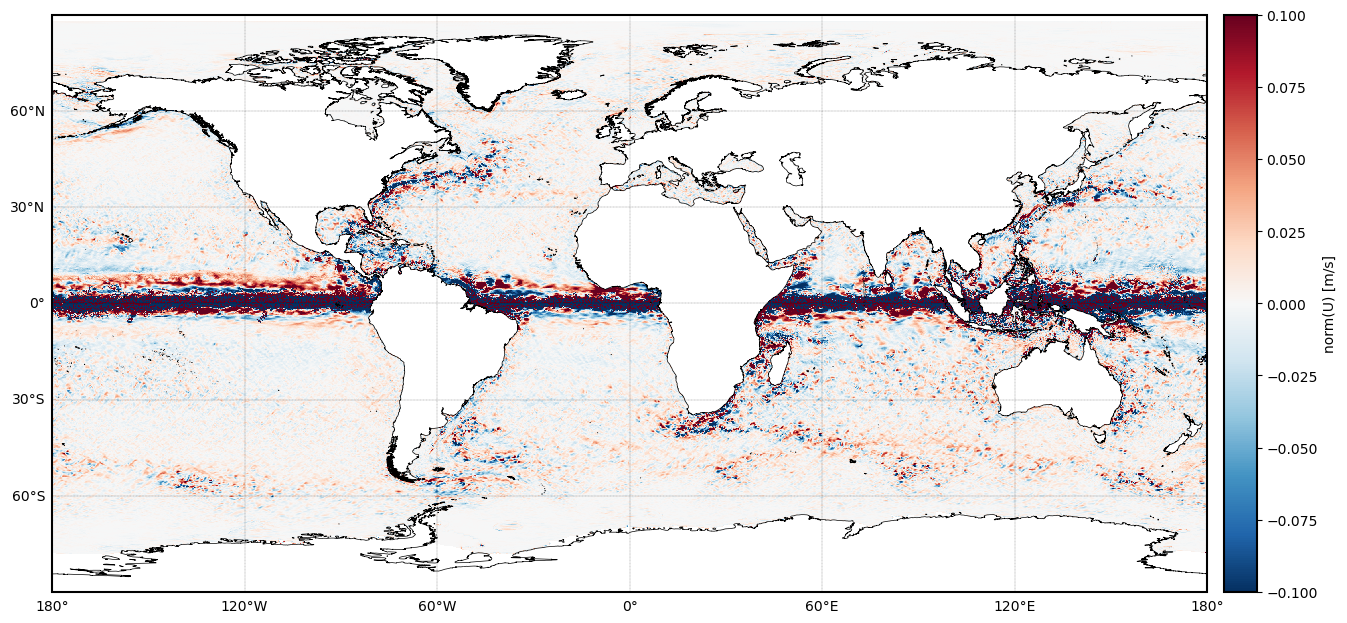

In [4]:
plot_uv_map(duacs.ugos-duacs_cyclo.ugos,duacs_cyclo.lon,duacs_cyclo.lat,vmin=-0.1,vmax=0.1)

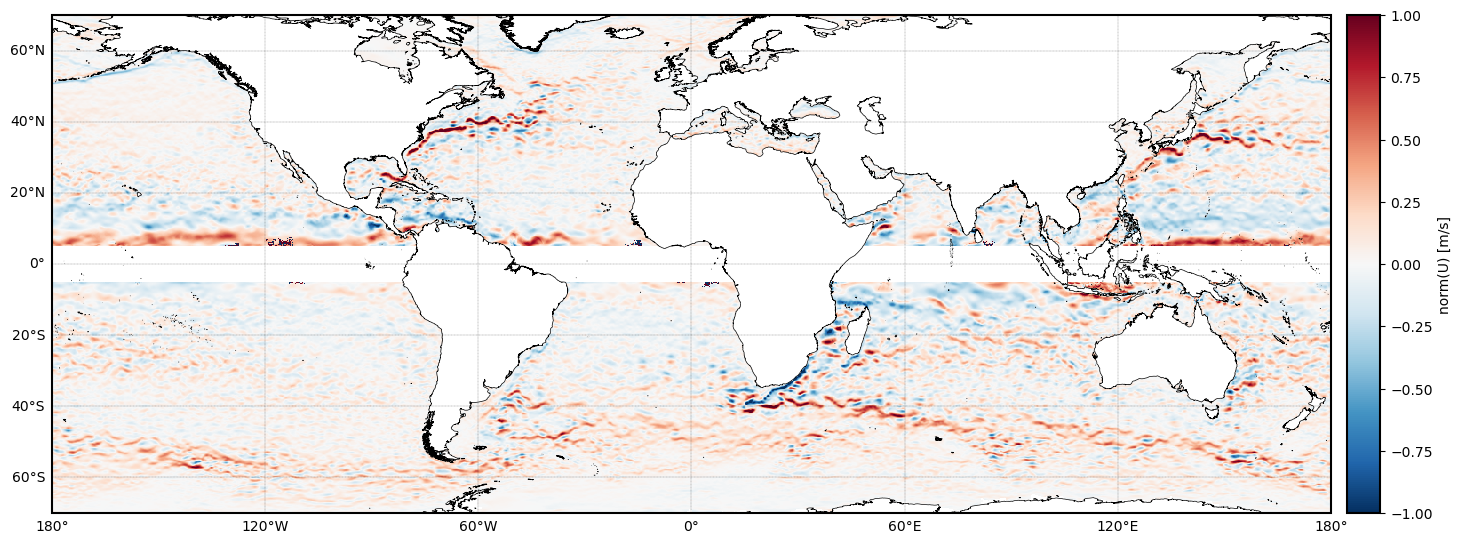

In [22]:
duacs_cyclo = duacs_cyclo.where(~( (duacs_cyclo.lat >= -5) & (duacs_cyclo.lat <= 5) ), np.nan)
plot_uv_map(duacs_cyclo.ugos,duacs_cyclo.lon,duacs_cyclo.lat)